In [1]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import vice

from astropy.table import Table
import astropy as ap
import astropy.units as u

import surp

modified solar abundances via mag++22


In [2]:
file_name = "../../data/allStar-dr17-synspec_rev1.fits.1"

ff = fits.open(file_name, mmap=True)
allStar = ff[1].data
ff.close()

In [3]:
filename = "../../data/apogee_astroNN-DR17.fits"

ff = fits.open(filename, mmap=True)
astroNN = ff[1].data

remove stars with
- STAR_BAD
- NO_ASPCAP_RESULT
- EXTRATARG=0

- R=3-13kpc
- |Z| < 2kpc
- -0.75 < Mg/H < 0.45
- S/N > 200 and Mg/H > -0.5
- SN ? 100 otherwise
- log g = 1-2.5
- Teff = 4000-4600

In [4]:
apogee_aspcapflag = 1<<23 # starbad
apogee_aspcapflag ^= 1<<31 # no_aspcap_result

In [5]:
mask = (allStar["ASPCAPFLAG"] & apogee_aspcapflag) == 0
mask &= allStar["EXTRATARG"] == 0

print(sum(mask))

364344


In [6]:
mg_h = allStar["MG_FE"] + allStar["FE_H"]
mask &= -0.75 <= mg_h
mask &= mg_h <= 0.45
mask &= allStar["SNR"] >= 100
mask &= (mg_h < -0.5)  | (allStar["SNR"] >= 200)

mask &= allStar["LOGG"] >= 1
mask &= allStar["LOGG"] <= 2.5
mask &= allStar["TEFF"] <= 4600
mask &= allStar["TEFF"] >= 4000

print(sum(mask))

29321


In [7]:
filtered = allStar[mask]

In [8]:
df = pd.DataFrame(filtered.tolist(), columns = [c.name for c in filtered.columns])

In [10]:
astroNN.columns

ColDefs(
    name = 'APOGEE_ID'; format = '18A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'TELESCOPE'; format = '8A'
    name = 'RA_APOGEE'; format = 'D'
    name = 'DEC_APOGEE'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'C_H'; format = 'E'
    name = 'C_H_ERR'; format = 'E'
    name = 'CI_H'; format = 'E'
    name = 'CI_H_ERR'; format = 'E'
    name = 'N_H'; format = 'E'
    name = 'N_H_ERR'; format = 'E'
    name = 'O_H'; format = 'E'
    name = 'O_H_ERR'; format = 'E'
    name = 'NA_H'; format = 'E'
    name = 'NA_H_ERR'; format = 'E'
    name = 'MG_H'; format = 'E'
    name = 'MG_H_ERR'; format = 'E'
    name = 'AL_H'; format = 'E'
    name = 'AL_H_ERR'; format = 'E'
    name = 'SI_H'; format = 'E'
    name = 'SI_H_ERR'; format = 'E'
    name = 'P_H'; format = 'E'
    name = 'P_H_ERR'; format = 'E'
    name = 'S_H'; format = 'E'
    name = 'S_H_ERR'; format 

In [41]:
df_aNN = pd.DataFrame(dict(
    R_gal = astroNN["galr"].byteswap().newbyteorder(),
    z_gal = astroNN["galz"].byteswap().newbyteorder(),
    vr_gal = astroNN["galvr"].byteswap().newbyteorder(),
    vt_gal = astroNN["galvt"].byteswap().newbyteorder(),
    vz_gal = astroNN["galvz"].byteswap().newbyteorder(),
    phi_gal = astroNN["galphi"].byteswap().newbyteorder(),
    age = astroNN["AGE_LOWESS_CORRECT"].byteswap().newbyteorder(),
),
    index = astroNN["APOGEE_ID"].byteswap().newbyteorder())
    



In [42]:
joined = df.join(df_aNN, on="APOGEE_ID", how="left")

In [43]:
len(joined)

31763

In [44]:
len(df)

29321

In [45]:
mask = np.abs(joined["z_gal"]) <= 2
mask &= joined["R_gal"] >= 3
mask &= joined["R_gal"] <= 13

In [46]:
df1 = joined[mask].copy()

df1["MG_H"] = df1["MG_FE"] + df1["FE_H"]
df1["MG_H"] = df1["MG_FE"] + df1["FE_H"]
df1["C_H"] = df1["C_FE"] + df1["FE_H"]
df1["N_H"] = df1["N_FE"] + df1["FE_H"]
df1["C_MG"] = df1["C_H"] - df1["MG_H"]
df1["N_MG"] = df1["N_H"] - df1["MG_H"]
df1["CN_H"] = surp.analysis.cpn(df1["C_H"], df1["N_H"])
df1["CN_MG"] = df1.CN_H - df1.MG_H


df1["high_alpha"] = surp.analysis.is_high_alpha(df1["MG_FE"], df1["FE_H"])

df1.to_csv("../../data/apogee_cartography.csv")

In [47]:
df_lm = df1[(~df1.high_alpha) & (df1.MG_H < -0.3)]

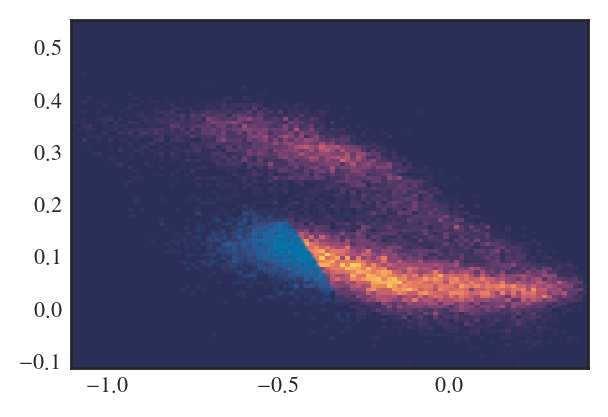

In [48]:
plt.hist2d(df1.FE_H, df1.MG_FE, 100);
plt.scatter(df_lm.FE_H, df_lm.MG_FE, s=0.3, alpha=0.1);

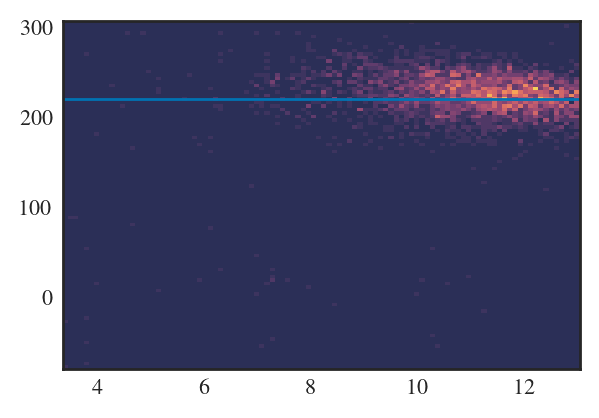

In [51]:
plt.hist2d(df_lm.R_gal, df_lm.vt_gal,bins=100);
plt.axhline(220)

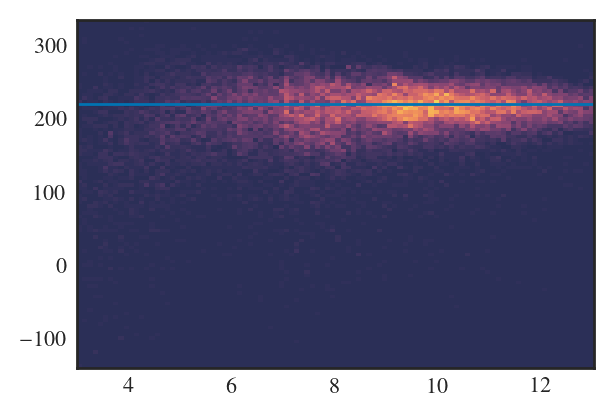

In [50]:
plt.hist2d(df1.R_gal, df1.vt_gal,bins=100);
plt.axhline(220)

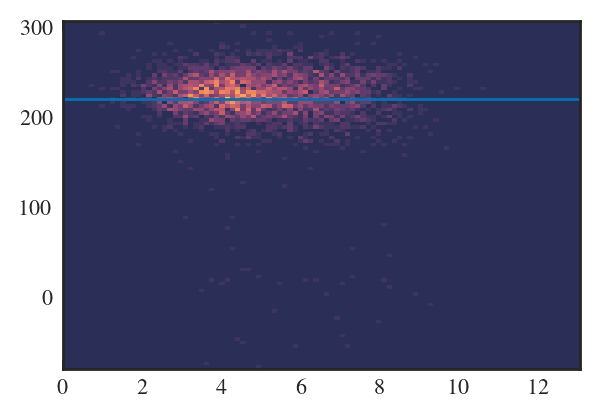

In [55]:
plt.hist2d(df_lm.age, df_lm.vt_gal, bins=(np.linspace(0, 13, 100), 100));
plt.axhline(220)

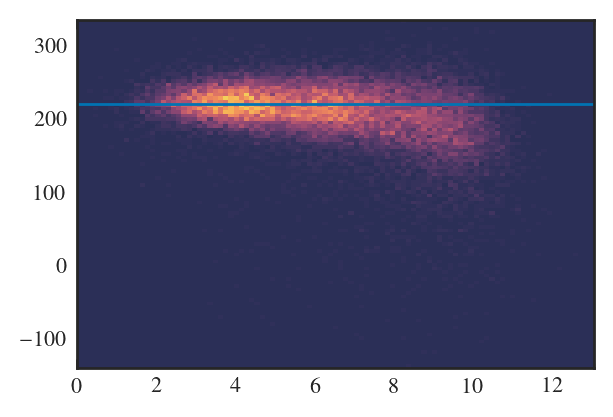

In [56]:
plt.hist2d(df1.age, df1.vt_gal, bins=(np.linspace(0, 13, 100), 100));
plt.axhline(220)

In [ ]:
len(df1)